# Team LUHG - groundwater challenge

This notebook describes the modeling and prediction process.  

The notebook was constructed using AWS SageMaker Lab and then later transferred to a fork of the groundwater challenge repository. Any effort to reconstruct the models (or load model weights, which can be sent upon request) may have to involve changing paths to reflect the directory structure of the user, so that files may be read properly and prevent the code from braking. For any questions that arise, please contact me (see contact details in the Team LUHG submission of the groundwater challenge repo).

The notebook is structured as follows:

1. Import packages and read provided data
2. Data preprocessing and visualization
    1. Feature engineering
    2. Curate model training / calibration input
    3. Prepare model prediction input
3. Model setup, training and prediction
    1. Sweden_1 training and calibration
    2. Sweden_1 prediction and export
    3. Sweden_2 training and calibration
    4. Sweden_2 prediction and export
    5. Netherlands training and calibration
    6. Netherlands prediction and export
    7. Germany training and calibration
    8. Germany prediction and export
    9. USA training and calibration
    10. USA prediction and export

A note on the Darts package: The Darts package is developed for timeseries *forecasting*. Therefore, by default, it does not allow the model to produce a prediction on the period of data that was used for training and calibration, but rather on a time-period occurring *after* that which the model has used to train and calibrate on. Because the participants of the groundwater challenge is required to produce predictions of hydraulic head for the entire period (including both training and prediction time), the default mode (or "limitation") of Darts had to be bypassed, so that the requests of the organizers could be fulfilled. This "limitation" of Darts was bypassed by temporally shifting the dates of the training data by the length of the training data during training / calibration. Afterwards, once the model was trained, the input data was temporally shifted back to its original dates, so that predictions covering the entire period could be produced.

In [1]:
#%pip install darts

In [3]:
#%pip install rich

## 1. Import packages and read provided data

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

import darts
from darts import TimeSeries

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts.dataprocessing.transformers import Scaler
from darts.models import NHiTSModel
from darts.utils.likelihood_models import GaussianLikelihood

from pytorch_lightning.callbacks import StochasticWeightAveraging, RichProgressBar

In [5]:
print(f'Darts version: {darts.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')

Darts version: 0.22.0
Numpy version: 1.23.5
Pandas version: 1.5.2


In [6]:
data_pth = os.path.join('..', 'data')

input_dfs, target_dfs = {}, {}

for i in os.listdir(data_pth):
    if '.' in i: # avoid including .ipynb... (might just be on my machine)
        pass
    elif 'USA' in i:
        pass
    else:
        series_path = os.path.join(data_pth, i) # i = USA
        
        series_input = os.path.join(series_path, 'input_data.csv')
        series_target = os.path.join(series_path, 'heads.csv')
        
        series_input_df = pd.read_csv(series_input)
        series_target_df = pd.read_csv(series_target)
        
        input_dfs[i], target_dfs[i] = series_input_df, series_target_df

In [7]:
# The USA dataset is handled separately (it contains different columns compared with the other datasets)
input_usa_df = pd.read_csv(os.path.join(data_pth, 'USA', 'input_data.csv'))
target_usa_df = pd.read_csv(os.path.join(data_pth, 'USA', 'heads.csv'))

## 2. Data preprocessing and visualization

Fix Datetime issues (datetime data-type and data frequency):

In [8]:
# Fix datetime
for k,v in input_dfs.items():
    v.rename(columns={'time': 'Date'}, inplace=True) # Rename time-column to Date to keep input and target data consistent
    v['Date'] = pd.to_datetime(v['Date']) # Change datatype from object to datetime64[ns]
    v.index = v['Date']
    v.drop('Date', axis=1, inplace=True) # drop Date column (it's redundant since the Date column is now the index)
    print(f'Input data frequency ({k}): {pd.infer_freq(v.index)}')
print('\n')

target_dfs['Netherlands'].rename(columns={'Unnamed: 0': 'Date'}, inplace=True) # For some reason this column was read without a header
for k,v in target_dfs.items():
    v['Date'] = pd.to_datetime(v['Date'])
    v.index = v['Date']
    v.drop('Date', axis=1, inplace=True)
    print(f'Target data frequency ({k}): {pd.infer_freq(v.index)}')
print('\n')

input_usa_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
for df in [input_usa_df, target_usa_df]:
    df['Date'] = pd.to_datetime(df['Date'])
    df.index = df['Date']
    df.drop('Date', axis=1, inplace=True)
print(f'Input data frequency (USA): {pd.infer_freq(input_usa_df.index)}')
print(f'Target data frequency (USA): {pd.infer_freq(target_usa_df.index)}')

Input data frequency (Sweden_1): D
Input data frequency (Sweden_2): D
Input data frequency (Germany): D
Input data frequency (Netherlands): D


Target data frequency (Sweden_1): W-TUE
Target data frequency (Sweden_2): W-TUE
Target data frequency (Germany): D
Target data frequency (Netherlands): None


Input data frequency (USA): D
Target data frequency (USA): None


In [9]:
# Convert target data frequency to 'D' (linear interpolation between known measurements of target data)
target_dfs['Netherlands'] = target_dfs['Netherlands'].resample('D').interpolate('linear')
target_dfs['Sweden_1'] = target_dfs['Sweden_1'].resample('D').interpolate('linear')
target_dfs['Sweden_2'] = target_dfs['Sweden_2'].resample('D').interpolate('linear')
target_usa_df = target_usa_df.resample('D').interpolate('linear')

for k,v in target_dfs.items():
    print(f'Target data frequency ({k}): {pd.infer_freq(v.index)}')
print(f'Target data frequency (USA): {pd.infer_freq(target_usa_df.index)}')
# Now both input data and target data is of daily frequency

Target data frequency (Sweden_1): D
Target data frequency (Sweden_2): D
Target data frequency (Germany): D
Target data frequency (Netherlands): D
Target data frequency (USA): D


Visualize European site's input data (using Sweden_1 as an example):

In [10]:
input_dfs['Sweden_1'].columns
# rr = Daily precipitation (mm/d)
# tg = Daily mean temperature (TG) in degree Celsius.
# tm = Daily minimum temperature (TM) in degree Celsius.
# tx = Daily maximum temperature (TX) in degree Celsius.
# pp = Daily averaged sea level pressure (PP) in hPa.
# hu = Daily averaged relative humidity (HU) in %.
# fg = Daily mean wind speed (FG) in m/s.
# qq = Daily mean global radiation (QQ) in W/m2.
# et = Potential evaporation (ET) computed with Makkink in mm/d.

Index(['rr', 'tg', 'tn', 'tx', 'pp', 'hu', 'fg', 'qq', 'et'], dtype='object')

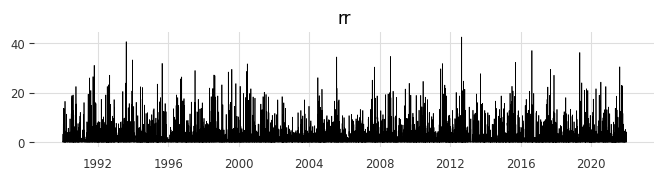

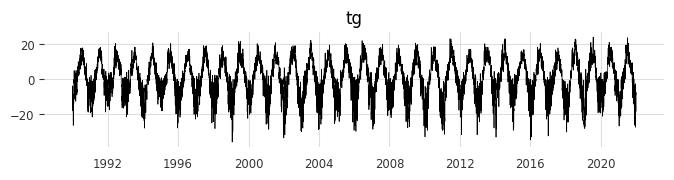

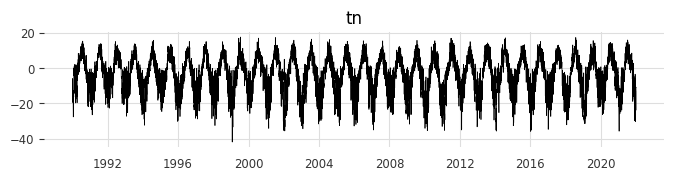

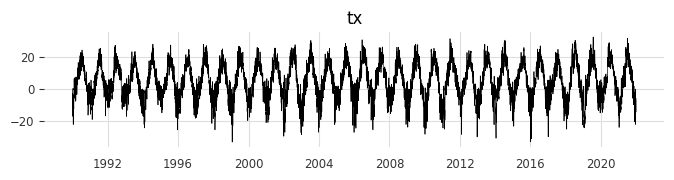

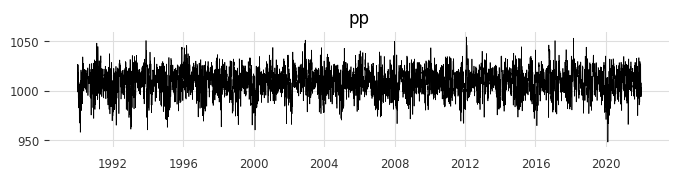

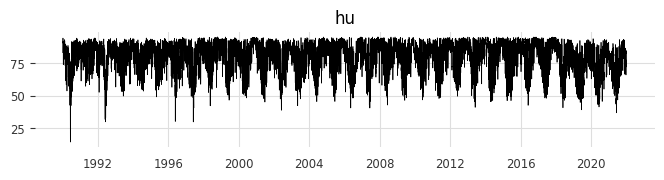

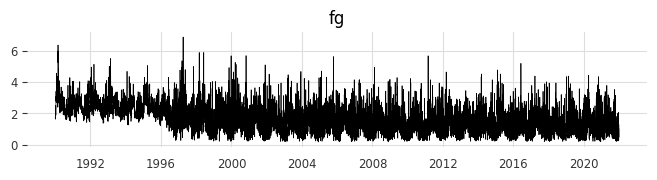

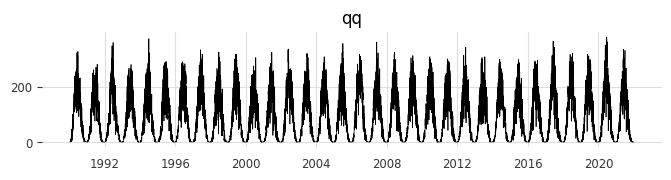

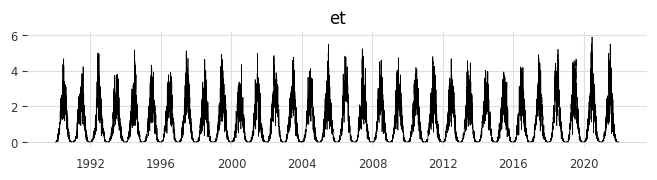

In [11]:
for col in input_dfs['Sweden_1'].columns:
    plt.figure(figsize=(8, 1.5))
    plt.plot(input_dfs['Sweden_1'].index, input_dfs['Sweden_1'][col], lw=0.5)
    plt.title(col)

Visualize US input data:

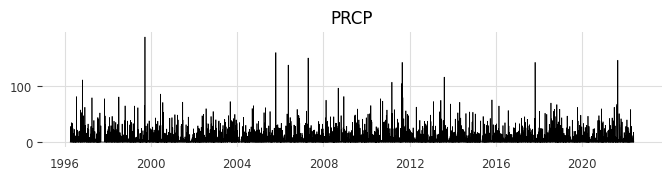

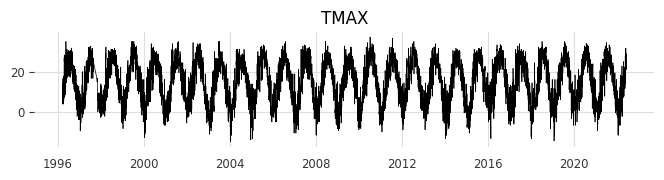

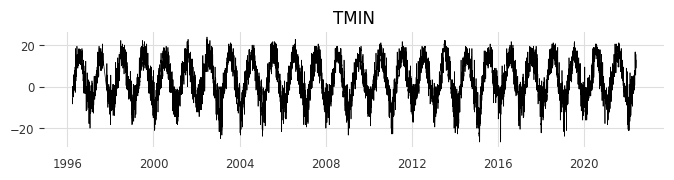

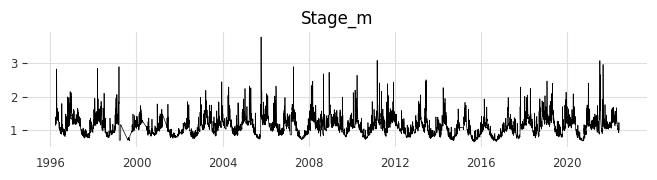

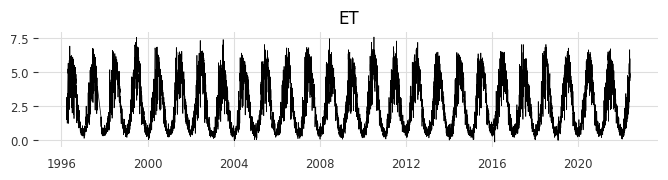

In [12]:
for col in input_usa_df.columns:
    plt.figure(figsize=(8, 1.5))
    plt.plot(input_usa_df.index, input_usa_df[col], lw=0.5)
    plt.title(col)

Visualize target data:

Text(0.5, 1.0, 'head')

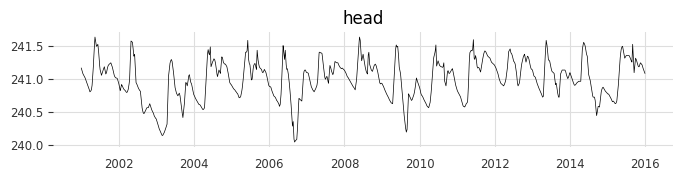

In [13]:
# Sweden
plt.figure(figsize=(8, 1.5))
plt.plot(target_dfs['Sweden_1'].index, target_dfs['Sweden_1']['head'].values, lw=0.5)
plt.title('head')

Text(0.5, 1.0, 'head')

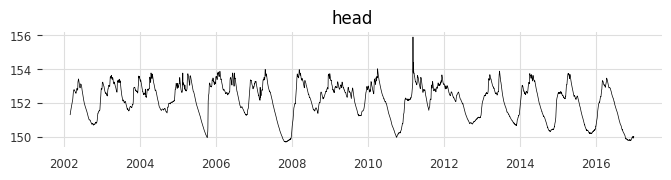

In [14]:
# USA
plt.figure(figsize=(8, 1.5))
plt.plot(target_usa_df.index, target_usa_df.values, lw=0.5)
plt.title('head')

### 2. A Feature engineering

Cumulative precipitation over the last 15, 30 and 60 days:

In [15]:
for k,v in input_dfs.items():
    v['rr15'] = v['rr'].rolling(min_periods=1, window=15).sum()
    v['rr30'] = v['rr'].rolling(min_periods=1, window=30).sum()
    v['rr60'] = v['rr'].rolling(min_periods=1, window=60).sum()

input_usa_df['PRCP15'] = input_usa_df['PRCP'].rolling(min_periods=1, window=15).sum()
input_usa_df['PRCP30'] = input_usa_df['PRCP'].rolling(min_periods=1, window=30).sum()
input_usa_df['PRCP60'] = input_usa_df['PRCP'].rolling(min_periods=1, window=60).sum()

Stream stage percent change since 30 days:

In [16]:
input_usa_df['STGPCTCH30'] = input_usa_df.Stage_m.pct_change(30)

In [17]:
input_dfs['Sweden_1'].tail()

,rr,tg,tn,tx,pp,hu,fg,qq,et,rr15,rr30,rr60
Date,,,,,,,,,,,,
2021-12-27,0.0,-16.869999,-20.789999,-12.86,1006.9,72.770004,0.27,1.0,0.003763,2.4,20.1,51.000000
2021-12-28,3.6,-18.359999,-23.800000,-14.53,1007.9,79.075005,1.02,1.0,0.003416,4.5,23.7,54.600001
2021-12-29,2.1,-10.690000,-13.830000,-9.55,1001.3,80.955000,0.73,1.0,0.005442,6.6,25.8,53.600001
2021-12-30,4.1,-7.390000,-10.760000,-6.67,994.0,84.570000,0.47,1.0,0.006498,10.7,29.9,57.700001
2021-12-31,0.0,-8.889999,-10.820000,-6.09,1002.9,82.595000,1.26,1.0,0.005982,10.7,26.6,55.500001


In [18]:
input_usa_df.tail()

,PRCP,TMAX,TMIN,Stage_m,ET,PRCP15,PRCP30,PRCP60,STGPCTCH30
Date,,,,,,,,,
2022-05-27,0.000,21.111111,8.888889,0.914355,4.372622,42.926,55.118,228.092,-0.248120
2022-05-28,17.526,25.555556,15.555556,0.978360,4.659461,60.452,72.136,245.618,-0.172680
2022-05-29,12.192,22.222222,8.888889,1.222188,4.665706,72.644,84.328,257.810,0.055263
2022-05-30,0.000,25.000000,9.444444,1.091131,5.309803,71.628,84.328,257.556,-0.040214
2022-05-31,0.254,28.888889,12.777778,1.005791,5.992429,65.278,84.582,233.934,-0.103261


### 2.B Curate model training / calibration input

In [19]:
# There is a mismatch in the challenge readme for the Swedish and US data and the provided target data. Dates used here are based on provided target data.
sweden_1_input_df = input_dfs['Sweden_1']['2001-01-02': '2015-12-29']
sweden_2_input_df = input_dfs['Sweden_2']['2001-01-02': '2015-12-29']
netherlands_input_df = input_dfs['Netherlands']['2000-01-01': '2015-09-10']
germany_input_df = input_dfs['Germany']['2002-05-01': '2016-12-31']
usa_input_df = input_usa_df['2002-03-01': '2016-12-26']

In [20]:
# Use 80% of the training data for actual training and the remaining 20% for validation / parameter updates
sweden_1_training_cutoff = int(len(sweden_1_input_df) * .8)
sweden_2_training_cutoff = int(len(sweden_2_input_df) * .8)
netherlands_training_cutoff = int(len(netherlands_input_df) * .8)
germany_training_cutoff = int(len(germany_input_df) * .8)
usa_training_cutoff = int(len(usa_input_df) * .8)

In order to overcome the limitation of the Darts library discussed above we must shift the training data back in time by `training_cutoff length`:

In [21]:
# Manipulate datetimeindex to bypass limitations of Darts
### ONLY RUN THIS BLOCK ONCE ###
sweden_1_input_df.index = sweden_1_input_df.index.shift(-sweden_1_training_cutoff, freq='D')
sweden_2_input_df.index = sweden_2_input_df.index.shift(-sweden_2_training_cutoff, freq='D')
netherlands_input_df.index = netherlands_input_df.index.shift(-netherlands_training_cutoff, freq='D')
germany_input_df.index = germany_input_df.index.shift(-germany_training_cutoff, freq='D')
usa_input_df.index = usa_input_df.index.shift(-usa_training_cutoff, freq='D')

In [22]:
# The same must now be done for the targets so that the model can calibrate
target_dfs['Sweden_1'].index = sweden_1_input_df.index
target_dfs['Sweden_2'].index = sweden_2_input_df.index
target_dfs['Netherlands'].index = netherlands_input_df.index
target_dfs['Germany'].index = germany_input_df.index
target_usa_df.index = usa_input_df.index

In [23]:
# Create Darts TimeSeries
sweden_1_input_ts = TimeSeries.from_dataframe(sweden_1_input_df)
sweden_1_target_ts = TimeSeries.from_dataframe(target_dfs['Sweden_1'])

sweden_2_input_ts = TimeSeries.from_dataframe(sweden_2_input_df)
sweden_2_target_ts = TimeSeries.from_dataframe(target_dfs['Sweden_2'])

netherlands_input_ts = TimeSeries.from_dataframe(netherlands_input_df)
netherlands_target_ts = TimeSeries.from_dataframe(target_dfs['Netherlands'])

germany_input_ts = TimeSeries.from_dataframe(germany_input_df)
germany_target_ts = TimeSeries.from_dataframe(target_dfs['Germany'])

usa_input_ts = TimeSeries.from_dataframe(usa_input_df)
usa_target_ts = TimeSeries.from_dataframe(target_usa_df)

In [24]:
# Ensure datatype is float32 (faster to train than float64)
sweden_1_input_ts = sweden_1_input_ts.astype(np.float32)
sweden_1_target_ts = sweden_1_target_ts.astype(np.float32)

sweden_2_input_ts = sweden_2_input_ts.astype(np.float32)
sweden_2_target_ts = sweden_2_target_ts.astype(np.float32)

netherlands_input_ts = netherlands_input_ts.astype(np.float32)
netherlands_target_ts = netherlands_target_ts.astype(np.float32)

germany_input_ts = germany_input_ts.astype(np.float32)
germany_target_ts = germany_target_ts.astype(np.float32)

usa_input_ts = usa_input_ts.astype(np.float32)
usa_target_ts = usa_target_ts.astype(np.float32)

In [25]:
# Split the data into training and validation sets
# Training and validation set contain 80 and 20 % of the data respectively
sweden_1_input_train, sweden_1_input_val = sweden_1_input_ts.split_after(0.8)
sweden_1_target_train, sweden_1_target_val = sweden_1_target_ts.split_after(0.8)

sweden_2_input_train, sweden_2_input_val = sweden_2_input_ts.split_after(0.8)
sweden_2_target_train, sweden_2_target_val = sweden_2_target_ts.split_after(0.8)

netherlands_input_train, netherlands_input_val = netherlands_input_ts.split_after(0.8)
netherlands_target_train, netherlands_target_val = netherlands_target_ts.split_after(0.8)

germany_input_train, germany_input_val = germany_input_ts.split_after(0.8)
germany_target_train, germany_target_val = germany_target_ts.split_after(0.8)

usa_input_train, usa_input_val = usa_input_ts.split_after(0.8)
usa_target_train, usa_target_val = usa_target_ts.split_after(0.8)

In [26]:
# Scale the data using only the training data (avoid "Look-ahead" bias)
scaler_sweden_1 = Scaler()
sweden_1_input_train_scaled, sweden_1_target_train_scaled = scaler_sweden_1.fit_transform([sweden_1_input_train, sweden_1_target_train])
sweden_1_input_val_scaled, sweden_1_target_val_scaled = scaler_sweden_1.transform([sweden_1_input_val, sweden_1_target_val])

scaler_sweden_2 = Scaler()
sweden_2_input_train_scaled, sweden_2_target_train_scaled = scaler_sweden_2.fit_transform([sweden_2_input_train, sweden_2_target_train])
sweden_2_input_val_scaled, sweden_2_target_val_scaled = scaler_sweden_2.transform([sweden_2_input_val, sweden_2_target_val])

scaler_netherlands = Scaler()
netherlands_input_train_scaled, netherlands_target_train_scaled = scaler_netherlands.fit_transform([netherlands_input_train, netherlands_target_train])
netherlands_input_val_scaled, netherlands_target_val_scaled = scaler_netherlands.transform([netherlands_input_val, netherlands_target_val])

scaler_germany = Scaler()
germany_input_train_scaled, germany_target_train_scaled = scaler_germany.fit_transform([germany_input_train, germany_target_train])
germany_input_val_scaled, germany_target_val_scaled = scaler_germany.transform([germany_input_val, germany_target_val])

scaler_usa = Scaler()
usa_input_train_scaled, usa_target_train_scaled = scaler_usa.fit_transform([usa_input_train, usa_target_train])
usa_input_val_scaled, usa_target_val_scaled = scaler_usa.transform([usa_input_val, usa_target_val])

### 2.C Prepare model prediction input

One the models are trained, they will be used to predict hydraulic head for the entire period.  
For the sake of keeping the notebook tidy, lets prepare the prediction input before training the model.

In [27]:
input_chunk_length = 30

In [28]:
# Prediction inputs for the four series including an extra 30 days (input_chunk_length) before the first
# date to predict (input_chunk_length is needed for each prediction).
sweden_1_pred_inputs = input_dfs['Sweden_1'][pd.Timestamp('2001-01-02') - pd.Timedelta(days=input_chunk_length):]
sweden_2_pred_inputs = input_dfs['Sweden_2'][pd.Timestamp('2001-01-02') - pd.Timedelta(days=input_chunk_length):]
netherlands_pred_inputs = input_dfs['Netherlands'][pd.Timestamp('2000-01-01') - pd.Timedelta(days=input_chunk_length):]
germany_pred_inputs = input_dfs['Germany'][pd.Timestamp('2002-05-01') - pd.Timedelta(days=input_chunk_length):]
usa_pred_inputs = input_usa_df[pd.Timestamp('2002-03-01') - pd.Timedelta(days=input_chunk_length):]

In [29]:
# create timeseries and ensure float32 (probably not needed since we're not retraining the model at this point)
sweden_1_pred_inputs_ts = TimeSeries.from_dataframe(sweden_1_pred_inputs)
sweden_1_pred_inputs_ts = sweden_1_pred_inputs_ts.astype(np.float32)

sweden_2_pred_inputs_ts = TimeSeries.from_dataframe(sweden_2_pred_inputs)
sweden_2_pred_inputs_ts = sweden_2_pred_inputs_ts.astype(np.float32)

netherlands_pred_inputs_ts = TimeSeries.from_dataframe(netherlands_pred_inputs)
netherlands_pred_inputs_ts = netherlands_pred_inputs_ts.astype(np.float32)

germany_pred_inputs_ts = TimeSeries.from_dataframe(germany_pred_inputs)
germany_pred_inputs_ts = germany_pred_inputs_ts.astype(np.float32)

usa_pred_inputs_ts = TimeSeries.from_dataframe(usa_pred_inputs)
usa_pred_inputs_ts = usa_pred_inputs_ts.astype(np.float32)

In [30]:
# Scale the input data
sweden_1_pred_inputs_ts_scaled = scaler_sweden_1.transform([sweden_1_pred_inputs_ts])[0]
sweden_2_pred_inputs_ts_scaled = scaler_sweden_2.transform([sweden_2_pred_inputs_ts])[0]
netherlands_pred_inputs_ts_scaled = scaler_netherlands.transform([netherlands_pred_inputs_ts])[0]
germany_pred_inputs_ts_scaled = scaler_germany.transform([germany_pred_inputs_ts])[0]
usa_pred_inputs_ts_scaled = scaler_usa.transform([usa_pred_inputs_ts])[0]

In [31]:
# We now have to shift back the target data by len(training_cutoff) so that we can predict the entire series
# Only execute once!!
target_dfs['Sweden_1'].index = target_dfs['Sweden_1'].index.shift(sweden_1_training_cutoff, freq='D') # Only execute once!!
target_dfs['Sweden_2'].index = target_dfs['Sweden_2'].index.shift(sweden_2_training_cutoff, freq='D') # Only execute once!!
target_dfs['Netherlands'].index = target_dfs['Netherlands'].index.shift(netherlands_training_cutoff, freq='D') # Only execute once!!
target_dfs['Germany'].index = target_dfs['Germany'].index.shift(germany_training_cutoff, freq='D') # Only execute once!!
target_usa_df.index = target_usa_df.index.shift(usa_training_cutoff, freq='D')

In [32]:
sweden_1_target_ts = TimeSeries.from_dataframe(target_dfs['Sweden_1'])
scaler_sweden_1_target = Scaler()
sweden_1_target_ts_scaled = scaler_sweden_1_target.fit_transform(sweden_1_target_ts)

sweden_2_target_ts = TimeSeries.from_dataframe(target_dfs['Sweden_2'])
scaler_sweden_2_target = Scaler()
sweden_2_target_ts_scaled = scaler_sweden_2_target.fit_transform(sweden_2_target_ts)

netherlands_target_ts = TimeSeries.from_dataframe(target_dfs['Netherlands'])
scaler_netherlands_target = Scaler()
netherlands_target_ts_scaled = scaler_netherlands_target.fit_transform(netherlands_target_ts)

germany_target_ts = TimeSeries.from_dataframe(target_dfs['Germany'])
scaler_germany_target = Scaler()
germany_target_ts_scaled = scaler_germany_target.fit_transform(germany_target_ts)

usa_target_ts = TimeSeries.from_dataframe(target_usa_df)
scaler_usa_target = Scaler()
usa_target_ts_scaled = scaler_usa_target.fit_transform(usa_target_ts)

## 3. Model setup and training
Note: The model setups, including callbacks, are commented out. This is because I've already trained the models in my environment and elect to load them using pre-trained weights. If you should want to instantiate and train them from scratch you are required to remove the comments and execute the code in the blocks below.

### 3. A Sweden_1 training and calibration

In [107]:
# Early stopping to reduce risk of overfitting
#early_stoping_sweden_1_cb = EarlyStopping(
#    monitor='val_loss',
#    patience=5,
#    min_delta=0.01,
#    mode='min',
#)

# Trainer callbacks
#sweden_1_pl_trainer_kwargs={
#    'callbacks': [
#        early_stoping_sweden_1_cb,
#        StochasticWeightAveraging(swa_lrs=1e-4),
#        RichProgressBar()
#    ],
#    'accelerator': 'cpu',
#    #'gpus': [0],
#    'enable_progress_bar' : True,
#    'enable_model_summary' : True,
#    'gradient_clip_val': 0.1,
#    #'accumulate_grad_batches': {0: 8, 20:4, 40:2, 60:1}
#}

In [238]:
#nhits_sweden_1 = NHiTSModel(
#    model_name="nhits_sweden_1",
#    dropout=0.1,
#    batch_size=2048,
#    n_epochs=200,
#    optimizer_kwargs = {"lr": 1e-4},
#    pl_trainer_kwargs = sweden_1_pl_trainer_kwargs,
#    input_chunk_length = input_chunk_length,
#    output_chunk_length = 5,
#    num_stacks=3,
#    num_blocks=2,
#    num_layers=2,
#    layer_widths=512,
#    log_tensorboard=True,
#    save_checkpoints=True,
#    force_reset=False,
#    likelihood=GaussianLikelihood(), # Gaussian likelyhood so we can produce a confidence interval
#)

In [239]:
#nhits_sweden_1.fit(
#    series = sweden_1_target_train_scaled, # this is the target series (hydraulic head) we want the model to learn
#    past_covariates = sweden_1_input_train_scaled, # these are the inputs (not including hydraulic head) the model should learn from
#    val_series = sweden_1_target_val_scaled, # used for calibration / parameter update
#    val_past_covariates = sweden_1_input_val_scaled, # used for calibration / parameter update
#    verbose=True
#)

Epoch 111/199 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 0:00:01 • 0:00:00 3.18it/s loss: -1.47 v_num: logs train_loss:
                                                                                -1.501 val_loss: -1.441            
Epoch 111/199 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 0:00:01 • 0:00:00 3.18it/s loss: -1.47 v_num: logs train_loss:
                                                                                -1.501 val_loss: -1.441            

In [358]:
# Save model weights (already done)
# nhits_sweden_1.save(os.path.join('..', 'saved_models', 'model_sweden_1.pth'))

In [50]:
# Load already trained model
nhits_sweden_1 = NHiTSModel.load(os.path.join('..', 'saved_models', 'model_sweden_1.pth'))

In [66]:
# Remove a callback used during training that cause an error at prediction time
nhits_sweden_1.trainer_params['callbacks'] = nhits_sweden_1.trainer_params['callbacks'][:-1]

### 3.B Sweden_1 prediction and export

In [67]:
# Draw 200 samples to explore confidence interval
pred_sweden_1 = nhits_sweden_1.predict(
    n = len(sweden_1_pred_inputs_ts_scaled) - input_chunk_length, # Predict the full time series
    past_covariates=sweden_1_pred_inputs_ts_scaled, # Predict using only input
    num_samples=200 # number of realizations so we can produce a confidence interval
)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:21 • 0:00:00 0.00it/s  
Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:21 • 0:00:00 0.00it/s

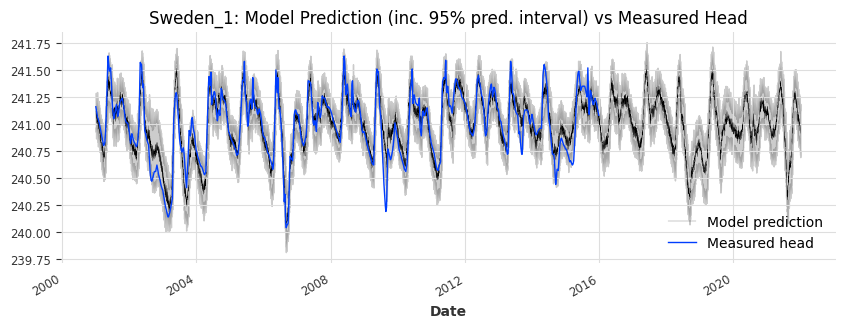

In [74]:
plt.figure(figsize=(10,3))
scaler_sweden_1_target.inverse_transform(pred_sweden_1).plot(lw=0.15, alpha=0.2, label='Model prediction', low_quantile=0.05, high_quantile=0.95)
sweden_1_target_ts.plot(lw=1., alpha=0.5, label='Measured head')
plt.title('Sweden_1: Model Prediction (inc. 95% pred. interval) vs Measured Head')
plt.savefig('Sweden_1-results.png')
plt.show()

In [75]:
sweden_1_results_df = scaler_sweden_1_target.inverse_transform(pred_sweden_1).quantiles_df([0.5, 0.05, 0.95]).reset_index()

In [76]:
# Rename columns as per requested..
sweden_1_results_df = sweden_1_results_df.rename(columns={'head_0.5': 'Simulated Head', 'head_0.05': '95% Lower Bound', 'head_0.95':'95% Upper Bound'})

In [112]:
display(sweden_1_results_df)

,Date,Simulated Head,95% Lower Bound,95% Upper Bound
0,2001-01-02,241.122810,240.927413,241.289647
1,2001-01-03,241.097931,240.971477,241.246616
2,2001-01-04,241.072029,240.929977,241.216924
3,2001-01-05,241.010902,240.866150,241.162553
4,2001-01-06,241.103477,240.929141,241.273207
...,...,...,...,...
7664,2021-12-27,240.976471,240.757847,241.191866
7665,2021-12-28,240.946121,240.713713,241.154925
7666,2021-12-29,240.944847,240.745158,241.126828
7667,2021-12-30,240.913055,240.692957,241.134810


In [108]:
sweden_1_results_df.to_csv('submission_form_Sweden_1_full.csv', index=None) # Daily output

In [109]:
sweden_1_results_df[::7].to_csv('submission_form_Sweden_1.csv', index=None) # Weekly output

### 3. C Sweden_2 training and calibration
Note that slightly different hyperparameters are used compare to Sweden_1. This is true for all models.

In [113]:
#early_stoping_sweden_2_cb = EarlyStopping(
#    monitor='val_loss',
#    patience=5,
#    min_delta=0.005,
#    mode='min',
#)

#sweden_2_pl_trainer_kwargs={
#    'callbacks': [
#        early_stoping_sweden_2_cb,
#        StochasticWeightAveraging(swa_lrs=1e-5),
#        RichProgressBar()
#    ],
#    'accelerator': 'cpu',
#    #'gpus': [0],
#    'enable_progress_bar' : True,
#    'enable_model_summary' : True,
#    'gradient_clip_val': 0.1,
#    'accumulate_grad_batches': {0: 8, 20:4, 40:2, 60:1}
#}

In [114]:
#nhits_sweden_2 = NHiTSModel(
#    model_name="nhits_sweden_2",
#    dropout=0.2,
#    batch_size=2048,
#    n_epochs=200,
#    optimizer_kwargs = {"lr": 1e-5},
#    pl_trainer_kwargs = sweden_2_pl_trainer_kwargs,
#    input_chunk_length = input_chunk_length,
#    output_chunk_length = 5,
#    num_stacks=3,
#    num_blocks=2,
#    num_layers=2,
#    layer_widths=512,
#    log_tensorboard=True,
#    save_checkpoints=True,
#    force_reset=False,
#    likelihood=GaussianLikelihood(),
#)

In [115]:
#nhits_sweden_2.fit(
#    series = sweden_2_target_train_scaled,
#    past_covariates = sweden_2_input_train_scaled,
#    val_series = sweden_2_target_val_scaled,
#    val_past_covariates = sweden_2_input_val_scaled,
#    verbose=True
#)

### 3. D Sweden_2 prediction and export

In [116]:
# Load already trained model
nhits_sweden_2 = NHiTSModel.load_from_checkpoint(os.path.join('nhits_sweden_2'))

In [117]:
pred_sweden_2 = nhits_sweden_2.predict(
    n = len(sweden_2_pred_inputs_ts_scaled) - input_chunk_length, # Predict the full time series
    past_covariates=sweden_2_pred_inputs_ts_scaled, # Prediction input
    num_samples=100 # number of realizations
)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:12 • 0:00:00 0.00it/s  
Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:12 • 0:00:00 0.00it/s

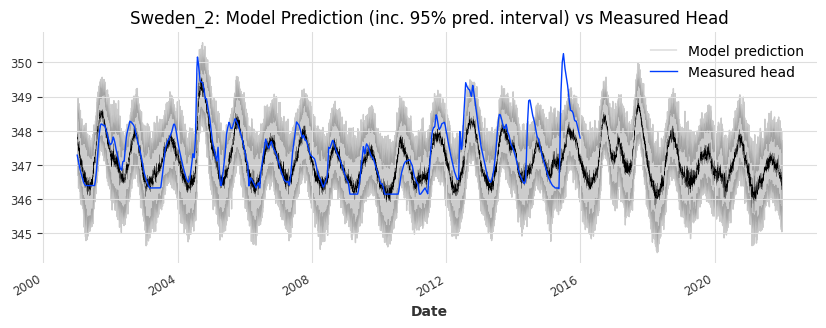

In [136]:
plt.figure(figsize=(10,3))
scaler_sweden_2_target.inverse_transform(pred_sweden_2).plot(lw=0.15, alpha=0.2, label='Model prediction', low_quantile=0.05, high_quantile=0.95)
sweden_2_target_ts.plot(lw=1., alpha=0.5, label='Measured head')
plt.title('Sweden_2: Model Prediction (inc. 95% pred. interval) vs Measured Head')
plt.savefig('Sweden_2-results.png')
plt.show()

In [119]:
sweden_2_results_df = scaler_sweden_2_target.inverse_transform(pred_sweden_2).quantiles_df([0.5, 0.05, 0.95]).reset_index()

In [120]:
# Rename columns as per requested..
sweden_2_results_df = sweden_2_results_df.rename(columns={'head_0.5': 'Simulated Head', 'head_0.05': '95% Lower Bound', 'head_0.95':'95% Upper Bound'})

In [121]:
sweden_2_results_df

,Date,Simulated Head,95% Lower Bound,95% Upper Bound
0,2001-01-02,347.740829,346.781894,348.772246
1,2001-01-03,347.847076,347.061484,348.565091
2,2001-01-04,347.919769,347.140546,348.766519
3,2001-01-05,347.772369,346.741087,348.658783
4,2001-01-06,347.759750,346.713866,348.960980
...,...,...,...,...
7664,2021-12-27,346.277115,345.063383,347.549036
7665,2021-12-28,346.389359,345.373601,347.407751
7666,2021-12-29,346.645447,345.622972,347.713612
7667,2021-12-30,346.556641,345.666699,347.552420


In [126]:
sweden_2_results_df.to_csv('submission_form_Sweden_2_full.csv', index=None) # Daily output

In [127]:
sweden_2_results_df[::7].to_csv('submission_form_Sweden_2.csv', index=None) # Weekly output

### 3.E Netherlands training and calibration

In [139]:
#early_stoping_netherlands_cb = EarlyStopping(
#    monitor='val_loss',
#    patience=5,
#    min_delta=0.01,
#    mode='min',
#)

#netherlands_pl_trainer_kwargs={
#    'callbacks': [
#        early_stoping_netherlands_cb,
#        StochasticWeightAveraging(swa_lrs=1e-4),
#        RichProgressBar()
#    ],
#    'accelerator': 'cpu',
#    #'gpus': [0],
#    'enable_progress_bar' : True,
#    'enable_model_summary' : True,
#    'gradient_clip_val': 0.1,
#    'accumulate_grad_batches': {0: 8, 20:4, 40:2, 60:1}
#}

In [140]:
#nhits_netherlands = NHiTSModel(
#    model_name='nhits_netherlands',
#    dropout=0.1,
#    batch_size=2048,
#    n_epochs=200,
#    optimizer_kwargs = {'lr': 7.5e-5},
#    pl_trainer_kwargs = netherlands_pl_trainer_kwargs,
#    input_chunk_length = input_chunk_length,
#    output_chunk_length = 5,
#    num_stacks=3,
#    num_blocks=2,
#    num_layers=2,
#    layer_widths=512,
#    log_tensorboard=True,
#    save_checkpoints=True,
#    force_reset=False,
#    likelihood=GaussianLikelihood(),
#)

In [141]:
#nhits_netherlands.fit(
#    series = netherlands_target_train_scaled,
#    past_covariates = netherlands_input_train_scaled,
#    val_series = netherlands_target_val_scaled,
#    val_past_covariates = netherlands_input_val_scaled,
#    verbose=True
#)

Epoch 135/199 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 0:00:01 • 0:00:00 2.80it/s loss: -1.47 v_num: logs train_loss:
                                                                                -1.449 val_loss: -1.42             
Epoch 135/199 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 0:00:01 • 0:00:00 2.80it/s loss: -1.47 v_num: logs train_loss:
                                                                                -1.449 val_loss: -1.42             

### 3.F Netherlands prediction and export

In [145]:
# Load already trained model
nhits_netherlands = NHiTSModel.load_from_checkpoint(os.path.join('nhits_netherlands'))

In [156]:
pred_netherlands = nhits_netherlands.predict(
    n = len(netherlands_pred_inputs_ts_scaled) - input_chunk_length, # Predict the full time series
    past_covariates=netherlands_pred_inputs_ts_scaled, # Prediction input
    num_samples=200 # number of realizations
)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:24 • 0:00:00 0.00it/s  
Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:24 • 0:00:00 0.00it/s

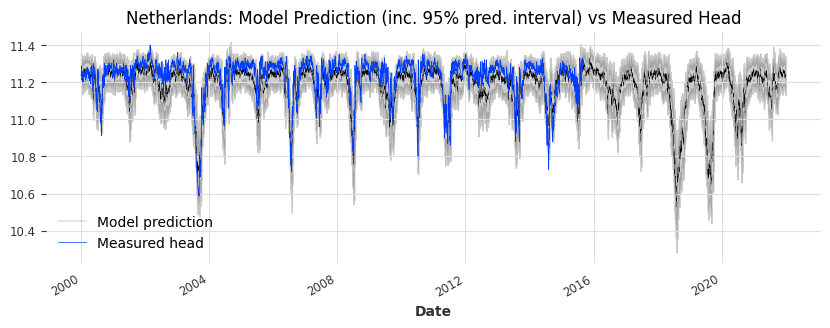

In [155]:
plt.figure(figsize=(10,3))
scaler_netherlands_target.inverse_transform(pred_netherlands).plot(lw=0.15, alpha=0.2, label='Model prediction', low_quantile=0.05, high_quantile=0.95)
netherlands_target_ts.plot(lw=0.5, alpha=0.5, label='Measured head')
plt.title('Netherlands: Model Prediction (inc. 95% pred. interval) vs Measured Head')
plt.savefig('Netherlands-results.png')
plt.show()

In [148]:
netherlands_results_df = scaler_netherlands_target.inverse_transform(pred_netherlands).quantiles_df([0.5, 0.05, 0.95]).reset_index()

In [149]:
# Rename columns as per requested..
netherlands_results_df = netherlands_results_df.rename(columns={'head_0.5': 'Simulated Head', 'head_0.05': '95% Lower Bound', 'head_0.95':'95% Upper Bound'})

In [151]:
netherlands_results_df

,Date,Simulated Head,95% Lower Bound,95% Upper Bound
0,2000-01-01,11.286500,11.206885,11.352625
1,2000-01-02,11.275298,11.209798,11.338405
2,2000-01-03,11.289445,11.218708,11.349631
3,2000-01-04,11.254714,11.176062,11.328217
4,2000-01-05,11.260045,11.184209,11.329802
...,...,...,...,...
8031,2021-12-27,11.244270,11.158818,11.295427
8032,2021-12-28,11.230758,11.164144,11.293522
8033,2021-12-29,11.239627,11.165060,11.303950
8034,2021-12-30,11.219841,11.131394,11.292552


In [152]:
netherlands_results_df.to_csv('submission_form_Netherlands.csv', index=None)

### 3.G Germany training and calibration

In [495]:
#early_stoping_germany_cb = EarlyStopping(
#    monitor='val_loss',
#    patience=5,
#    min_delta=0.01,
#    mode='min',
#)

#germany_pl_trainer_kwargs={
#    'callbacks': [
#        early_stoping_germany_cb,
#        StochasticWeightAveraging(swa_lrs=5e-5),
#        RichProgressBar()
#    ],
#    'accelerator': 'cpu',
#    #'gpus': [0],
#    'enable_progress_bar' : True,
#    'enable_model_summary' : True,
#    'gradient_clip_val': 0.1,
#    'accumulate_grad_batches': {0: 8, 20:4, 40:2, 60:1} #, 20: 4, 80: 2
#}

In [496]:
#nhits_germany = NHiTSModel(
#    model_name='nhits_germany',
#    dropout=0.1,
#    batch_size=2048,
#    n_epochs=200,
#    optimizer_kwargs = {'lr': 1e-5},
#    pl_trainer_kwargs = germany_pl_trainer_kwargs,
#    input_chunk_length = input_chunk_length,
#    output_chunk_length = 5,
#    num_stacks=3,
#    num_blocks=2,
#    num_layers=2,
#    layer_widths=512,
#    log_tensorboard=True,
#    save_checkpoints=True,
#    force_reset=True,
#    likelihood=GaussianLikelihood(),
#)

In [497]:
#nhits_germany.fit(
#    series = germany_target_train_scaled,
#    past_covariates = germany_input_train_scaled,
#    val_series = germany_target_val_scaled,
#    val_past_covariates = germany_input_val_scaled,
#    verbose=True
#)

Epoch 125/199 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 0:00:01 • 0:00:00 2.74it/s loss: -0.87 v_num: logs train_loss:
                                                                                -0.914 val_loss: -0.943            
Epoch 125/199 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 0:00:01 • 0:00:00 2.74it/s loss: -0.87 v_num: logs train_loss:
                                                                                -0.914 val_loss: -0.943            

### 3.H Germany prediction and export

In [153]:
nhits_germany = NHiTSModel.load_from_checkpoint(os.path.join('..', 'darts_logs', 'nhits_germany'), best=True)

In [157]:
pred_germany = nhits_germany.predict(
    n = len(germany_pred_inputs_ts_scaled) - input_chunk_length, # Predict the full time series
    past_covariates=germany_pred_inputs_ts_scaled, # Prediction input
    num_samples=200 # number of realizations
)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:19 • 0:00:00 0.00it/s  
Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:19 • 0:00:00 0.00it/s

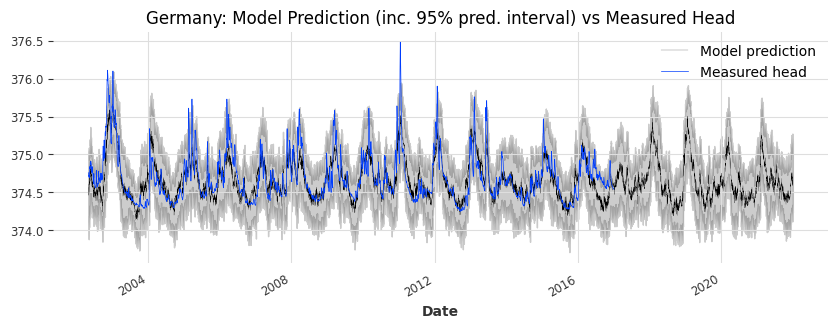

In [158]:
plt.figure(figsize=(10,3))
scaler_germany_target.inverse_transform(pred_germany).plot(lw=0.15, alpha=0.2, label='Model prediction', low_quantile=0.05, high_quantile=0.95)
germany_target_ts.plot(lw=0.5, alpha=0.5, label='Measured head')
plt.title('Germany: Model Prediction (inc. 95% pred. interval) vs Measured Head')
plt.savefig('Germany-results.png')
plt.show()

In [159]:
germany_results_df = scaler_germany_target.inverse_transform(pred_germany).quantiles_df([0.5, 0.05, 0.95]).reset_index()

In [160]:
# Rename columns as per requested..
germany_results_df = germany_results_df.rename(columns={'head_0.5': 'Simulated Head', 'head_0.05': '95% Lower Bound', 'head_0.95':'95% Upper Bound'})

In [161]:
germany_results_df

,Date,Simulated Head,95% Lower Bound,95% Upper Bound
0,2002-05-01,374.566528,374.039561,375.046469
1,2002-05-02,374.537277,374.117424,375.019321
2,2002-05-03,374.489044,374.076338,374.997067
3,2002-05-04,374.462341,373.978664,374.933786
4,2002-05-05,374.463867,373.882213,375.056638
...,...,...,...,...
7180,2021-12-27,374.588943,374.138223,375.044356
7181,2021-12-28,374.599625,374.248137,375.002605
7182,2021-12-29,374.759567,374.339131,375.214484
7183,2021-12-30,374.691650,374.304424,375.211537


In [210]:
germany_results_df.to_csv('submission_form_Germany.csv', index=None)

### 3.I USA prediction and export

In [192]:
#early_stoping_usa_cb = EarlyStopping(
#    monitor='val_loss',
#    patience=5,
#    min_delta=0.01,
#    mode='min',
#)

#usa_pl_trainer_kwargs={
#    'callbacks': [
#        early_stoping_usa_cb,
#        StochasticWeightAveraging(swa_lrs=5e-5),
#        RichProgressBar()
#    ],
#    'accelerator': 'cpu',
#    #'gpus': [0],
#    'enable_progress_bar' : True,
#    'enable_model_summary' : True,
#    'gradient_clip_val': 0.1,
#    'accumulate_grad_batches': {0: 8, 20:4, 40:2, 60:1}
#}

In [193]:
#nhits_usa = NHiTSModel(
#    model_name='nhits_usa',
#    dropout=0.1,
#    batch_size=2048,
#    n_epochs=200,
#    optimizer_kwargs = {'lr': 5e-5},
#    pl_trainer_kwargs = usa_pl_trainer_kwargs,
#    input_chunk_length = input_chunk_length,
#    output_chunk_length = 5,
#    num_stacks=3,
#    num_blocks=2,
#    num_layers=2,
#    layer_widths=512,
#    log_tensorboard=True,
#    save_checkpoints=True,
#    force_reset=False,
#    likelihood=GaussianLikelihood(),
#)

In [194]:
#nhits_usa.fit(
#    series = usa_target_train_scaled,
#    past_covariates = usa_input_train_scaled,
#    val_series = usa_target_val_scaled,
#    val_past_covariates = usa_input_val_scaled,
#    verbose=True
#)

Epoch 118/199 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 0:00:03 • 0:00:00 1.43it/s loss: -1.4 v_num: logs train_loss: 
                                                                                -1.422 val_loss: -1.416            
Epoch 118/199 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 0:00:03 • 0:00:00 1.43it/s loss: -1.4 v_num: logs train_loss: 
                                                                                -1.422 val_loss: -1.416            

In [198]:
#nhits_usa.save(os.path.join('..', 'saved_models', 'usa.pth'))

In [163]:
nhits_usa = NHiTSModel.load(os.path.join('..', 'saved_models', 'usa.pth'))

In [165]:
# Remove a callback used during training that cause an error at prediction time
nhits_usa.trainer_params['callbacks'] = nhits_usa.trainer_params['callbacks'][:-1]

In [166]:
pred_usa = nhits_usa.predict(
    n = len(usa_pred_inputs_ts_scaled) - input_chunk_length, # Predict the full time series
    past_covariates=usa_pred_inputs_ts_scaled, # Prediction input
    num_samples=100 # number of realizations
)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:11 • 0:00:00 0.00it/s  
Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:11 • 0:00:00 0.00it/s

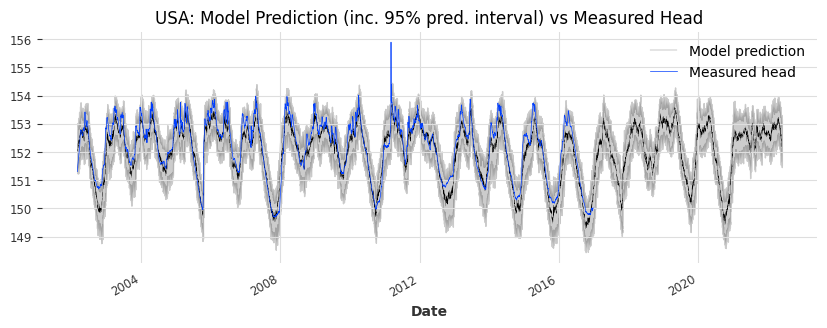

In [167]:
plt.figure(figsize=(10,3))
scaler_usa_target.inverse_transform(pred_usa).plot(lw=0.15, alpha=0.2, label='Model prediction', low_quantile=0.05, high_quantile=0.95)
usa_target_ts.plot(lw=0.5, alpha=0.5, label='Measured head')
plt.title('USA: Model Prediction (inc. 95% pred. interval) vs Measured Head')
plt.savefig('USA-results.png')
plt.show()

In [168]:
usa_results_df = scaler_usa_target.inverse_transform(pred_usa).quantiles_df([0.5, 0.05, 0.95]).reset_index()

In [169]:
# Rename columns as per requested..
usa_results_df = usa_results_df.rename(columns={'head_0.5': 'Simulated Head', 'head_0.05': '95% Lower Bound', 'head_0.95':'95% Upper Bound'})

In [170]:
usa_results_df

,Date,Simulated Head,95% Lower Bound,95% Upper Bound
0,2002-03-01,152.036484,151.326608,152.703503
1,2002-03-02,152.068008,151.285352,152.852072
2,2002-03-03,152.099289,151.343728,152.935989
3,2002-03-04,152.017609,151.236871,152.986362
4,2002-03-05,152.060364,151.396184,153.026663
...,...,...,...,...
7392,2022-05-27,152.397621,151.726596,153.116737
7393,2022-05-28,152.373840,151.642931,153.122261
7394,2022-05-29,152.470200,151.944847,152.954078
7395,2022-05-30,152.184418,151.462082,152.897410


In [171]:
usa_results_df.to_csv('submission_form_USA.csv', index=None)

End of notebook.